# Principal Component Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA

## Datensatz

Wir betrachten wieder einen Datensatz mit handgeschriebenen Ziffern, diesmal allerdings in etwas höherer Auflösung (28x28 statt 8x8). Außerdem haben wir wesentlich mehr Datensätze zur Verfügung.

Die 28x28 Pixel ergeben 784 Features, d.h. unser Ausgangsraum ist $\mathbb{R}^{784}$.

Wir haben 42000 Datenpunkte mit 784 Features
Drei Beispielbilder:


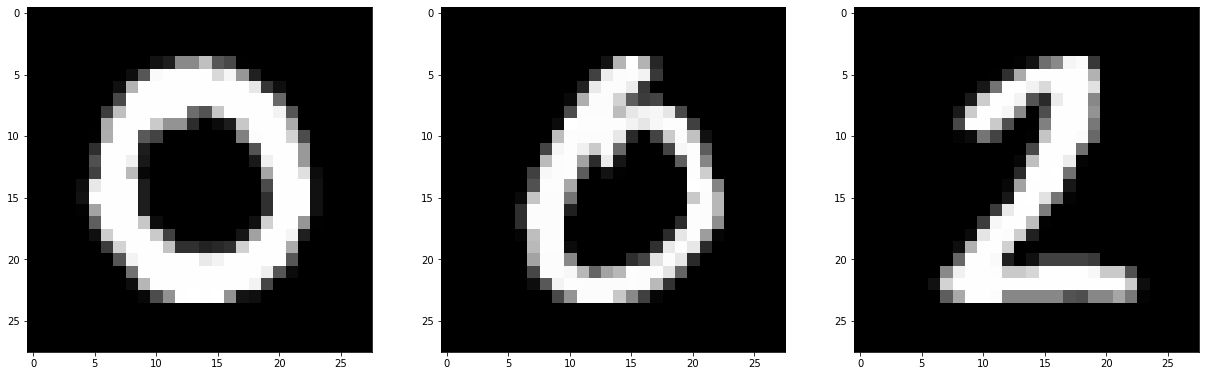

In [2]:
train = pd.read_csv('./data/mnist/train.csv')
target = train.label
train = train.drop("label",axis=1)
m,n = train.shape
print(f'Wir haben {m} Datenpunkte mit {n} Features')
print('Drei Beispielbilder:')
fig, axs = plt.subplots(1,3, figsize=(21,7))
for idx, i in enumerate([1,200,40000]):
    axs[idx].imshow(np.asarray(train.iloc[i]).reshape(28,28), cmap='gray');

## Skalierung

In [3]:
from sklearn.preprocessing import StandardScaler
X = train
scaler = StandardScaler().fit(X)
print(f'Skalierer: {scaler}')
X_std = scaler.transform(X)
X_std.shape

Skalierer: StandardScaler(copy=True, with_mean=True, with_std=True)


(42000, 784)

## Eigenwertzerlegung

Die Eigenvektoren und Eigenwerte der Kovarianz-Matrix stellen den "Kern" einer PCA dar: 
Die Eigenvektoren (Hauptkomponenten/Principal Components) bestimmen die Richtungen
des neuen Feature-Raums, und die Eigenwerte bestimmen ihre Größe. 

Mit anderen Worten: Die Eigenwerte erklären die Varianz der Daten entlang der Achsen (Eigenvektoren) der transformierten Merkmale.

In [4]:
mean_vec = np.mean(X_std, axis=0)
cov = np.dot((X_std-mean_vec).T, X_std-mean_vec)/(m-1)
cov.shape

(784, 784)

In [5]:
eig_vals, eig_vecs = np.linalg.eig(cov)
eig_vals.shape, eig_vecs.shape

((784,), (784, 784))

Wir sortieren die Eigenwerte nach absteigender Größe, denn sie tragen gemäß ihrer Größe ihren Anteil an der Varianz der Daten (also nach unserer Grundannahme dem Informationsgehalt der Daten) bei:

In [6]:
tot = sum(eig_vals)

var_exp = [(i/tot) for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

## Plot der erklärten Varianz

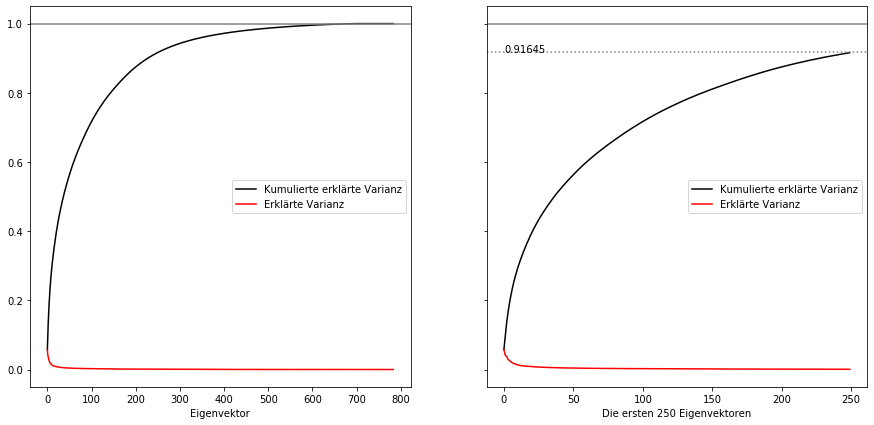

In [7]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15,7))

axs[0].plot(list(range(n)), cum_var_exp, c='black', label='Kumulierte erklärte Varianz')
axs[0].plot(list(range(n)), var_exp, c='red', label='Erklärte Varianz')
axs[0].set_xlabel('Eigenvektor')
axs[0].axhline(1, c='grey')
axs[0].legend();

k = 250
axs[1].plot(list(range(k)), cum_var_exp[:k], c='black', label='Kumulierte erklärte Varianz')
axs[1].plot(list(range(k)), var_exp[:k], c='red', label='Erklärte Varianz')
axs[1].set_xlabel(f'Die ersten {k} Eigenvektoren')
axs[1].axhline(1, c='grey')
axs[1].axhline(cum_var_exp[k], c='grey', linestyle='dotted')
axs[1].text(0, cum_var_exp[k], f'{cum_var_exp[k]:.5f}')
axs[1].legend();



D.h. mit den ersten 250 der 784 Principal-Component-Features würden wir schon **über 90% der Varianz** abdecken.

## Scikit Learn's PCA

Scikit spart uns die Mühe selber Kovarianz und Eigenwerte zu ermitteln und verpackt PCA in einen fertigen Algorithmus:

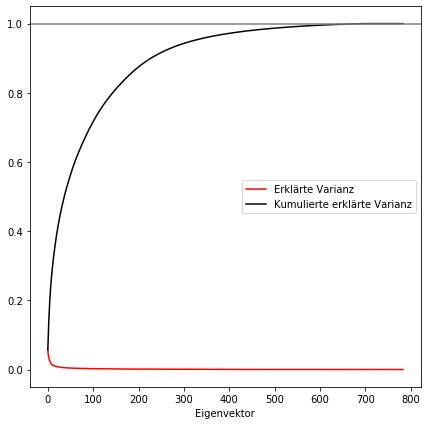

In [8]:
pca = PCA().fit(X_std)

eigenvectors = pca.components_
cumul = np.cumsum(pca.explained_variance_ratio_)
fig, ax = plt.subplots(1, 1, figsize=(7,7))

ax.plot(list(range(n)), pca.explained_variance_ratio_, c='red', label='Erklärte Varianz')
ax.plot(list(range(n)), cumul, c='black', label='Kumulierte erklärte Varianz')
ax.set_xlabel('Eigenvektor')
ax.axhline(1, c='grey')
ax.legend();


## Plotte Eigenvektoren

Unsere Eigenvektoren sind Vektoren in $\mathbb{R}^{784}$. Gleichzeitig sind diese Vektoren aber ja auch jeweils die Pixel eines 28x28 Bildes.

D.h. wir können auch unsere Eigenvektoren als Bilder anschauen:

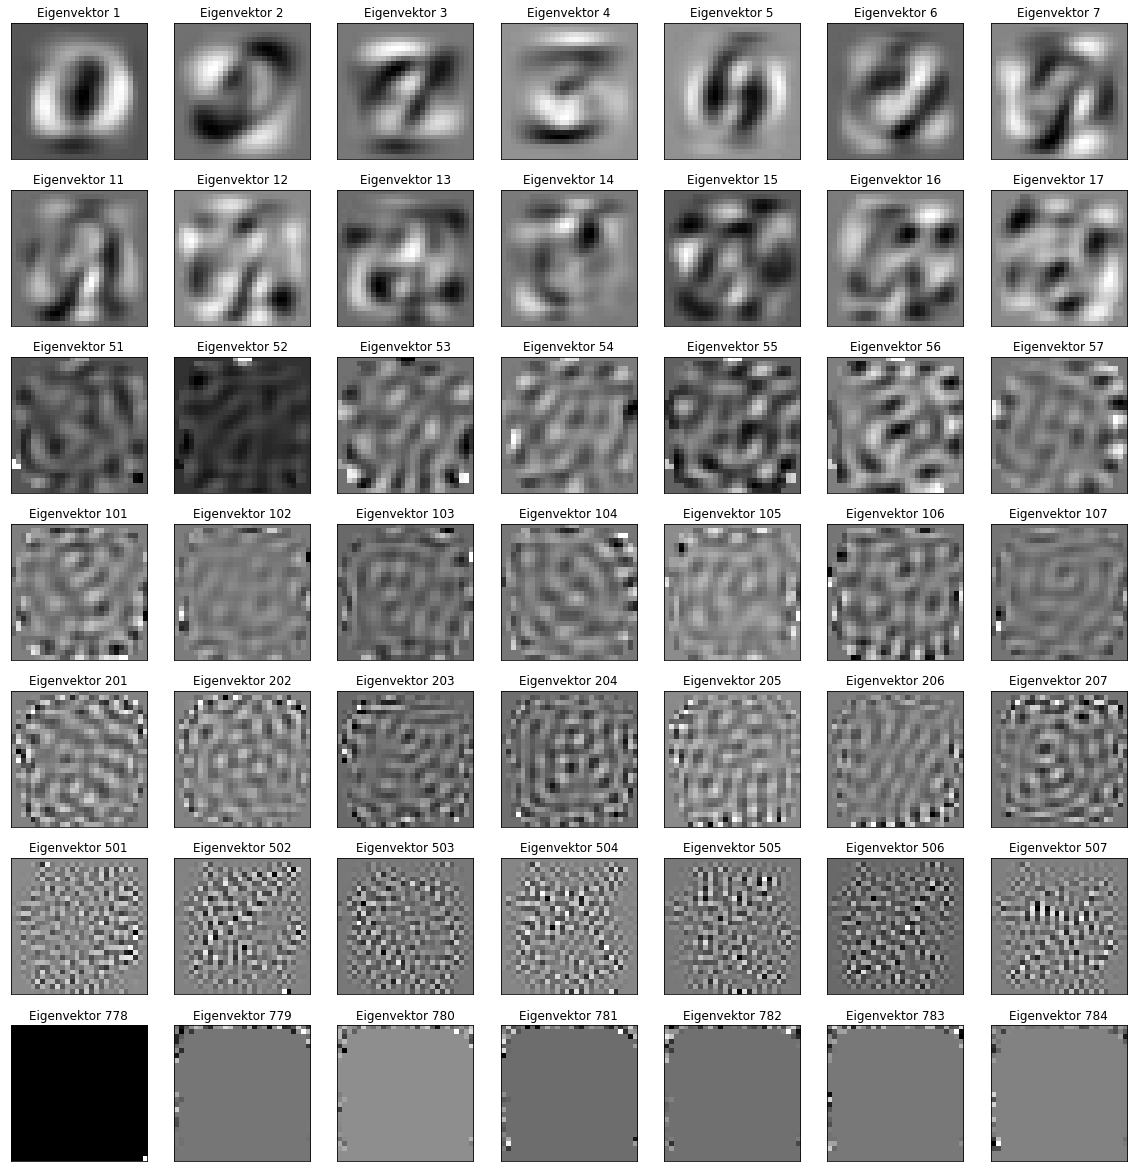

In [9]:
n_row = 7
n_col = 7

fig, axs = plt.subplots(n_row, n_col, figsize=(20,3*n_row))

def plot_eigenvectors(row, col, eigenvector_nr):
    ax = axs[row, col]
    ax.imshow(eigenvectors[eigenvector_nr].reshape(28,28), cmap='gray') # Alternativ in Farbe: jet
    title_text = f'Eigenvektor {eigenvector_nr + 1}'
    ax.set_title(title_text, size=12)
    ax.set_xticks(())
    ax.set_yticks(())

offsets = [0, 10, 50, 100, 200, 500, n-n_col]

for i in list(range(n_row)):
    for j in range(n_col):
        plot_eigenvectors(i, j, offsets[i] + j)

plt.show()

Wir sehen, dass die Eigenvektoren mit großen Strukturen anfangen und in der Folge immer feiner werden. Das passt zu unserer Intuition, dass mit den größten Eigenwerten zunächst die wichtigsten Features erfasst werden und am Schluss der Reihe nur noch kleinste Details abgebildet werden.

In diesem Fall hier kann man tatsächlich den Featureraum um etwa 200 Dimensionen verkleinern.

## Deutung der transformierten Features

Ein Nachteil von PCA ist, dass die transformierten Features i.d.R. schwer zu erklären sind.

Schauen wir uns drei Bilder im transformierten Raum an:

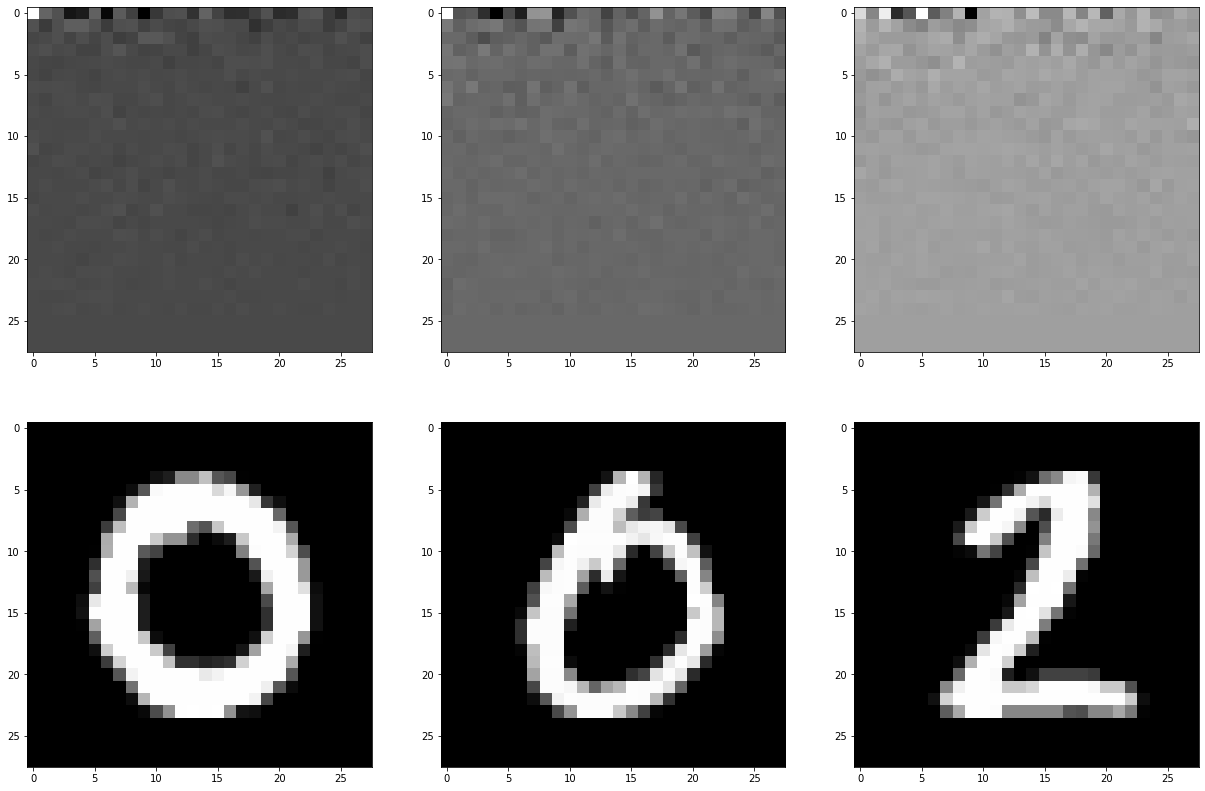

In [10]:
fig, (axst, axsr) = plt.subplots(2,3, figsize=(21,14))
for idx, i in enumerate([1,200,40000]):
    image = np.asarray(train.iloc[i])
    transformed = pca.transform([image])
    axst[idx].imshow(transformed.reshape(28,28), cmap='gray');
    axsr[idx].imshow(image.reshape(28,28), cmap='gray');